In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置中文显示
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 读取两个数据集
选择了**所有学员**的`IP使用情况` 和 `OPENID使用情况` 两个数据集,  
因为这两个数据集都包含了同样含义的 `_id` 字段，可以 join 两个数据集。

In [14]:
f1 = '../../data/周一所获数据/所有学员的IP使用情况.csv'
f2 = '../../data/周一所获数据/所有学员的OPENID使用情况.csv'

df_ip = pd.read_csv(f1, dtype={'_id': 'string', 'ipCount': 'int'})
df_openid = pd.read_csv(f2, dtype={'openIdCount': 'int64', 'openIds': 'string'})

# 将 'ips' 字段转换为数组类型 
df_ip['ips'] = df_ip['ips'].apply(lambda x: x.split(','))

In [15]:
# 查看数据
df_ip.shape  # (11211, 3)
df_openid.shape  # (11218, 3)

(11218, 3)

# 按照 id 列连接两个数据集

In [16]:
df = pd.merge(df_ip, df_openid, on='_id', how='inner')

只保留 `ipCount`, `openIdCount` 两列

In [17]:
# 只保留 `ipCount`, `openIdCount` 两列.并保存为 csv 文件
df = df[['_id', 'ipCount', 'openIdCount']]
df.to_csv('./所有学员的IP和OPENID使用情况.csv', index=False)

In [18]:
df.shape
df.head(100)

,_id,ipCount,openIdCount
0,018f72e710a811ec8871b07b25146e9e,50,3
1,6f88968110c911ec8216b07b25146e9e,25,4
2,991036f110a911ec8871b07b25146e9e,25,3
3,8c94bab110a911ec8871b07b25146e9e,24,1
4,423d3e1210a911ec8871b07b25146e9e,21,1
...,...,...,...
95,bb47779110a811ec8871b07b25146e9e,9,1
96,776da7808cf011edb6a3fa164011f743,9,1
97,9951743810a911ec8871b07b25146e9e,9,1
98,0b372a0067bc11ecb369fa164011f743,9,1


# 数据量纲不一致，需要对数据进行归一化处理

# 3. 绘制图表

In [19]:
# 中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

### (1) 按照 IP 数量和 OpenID 数量绘制散点图

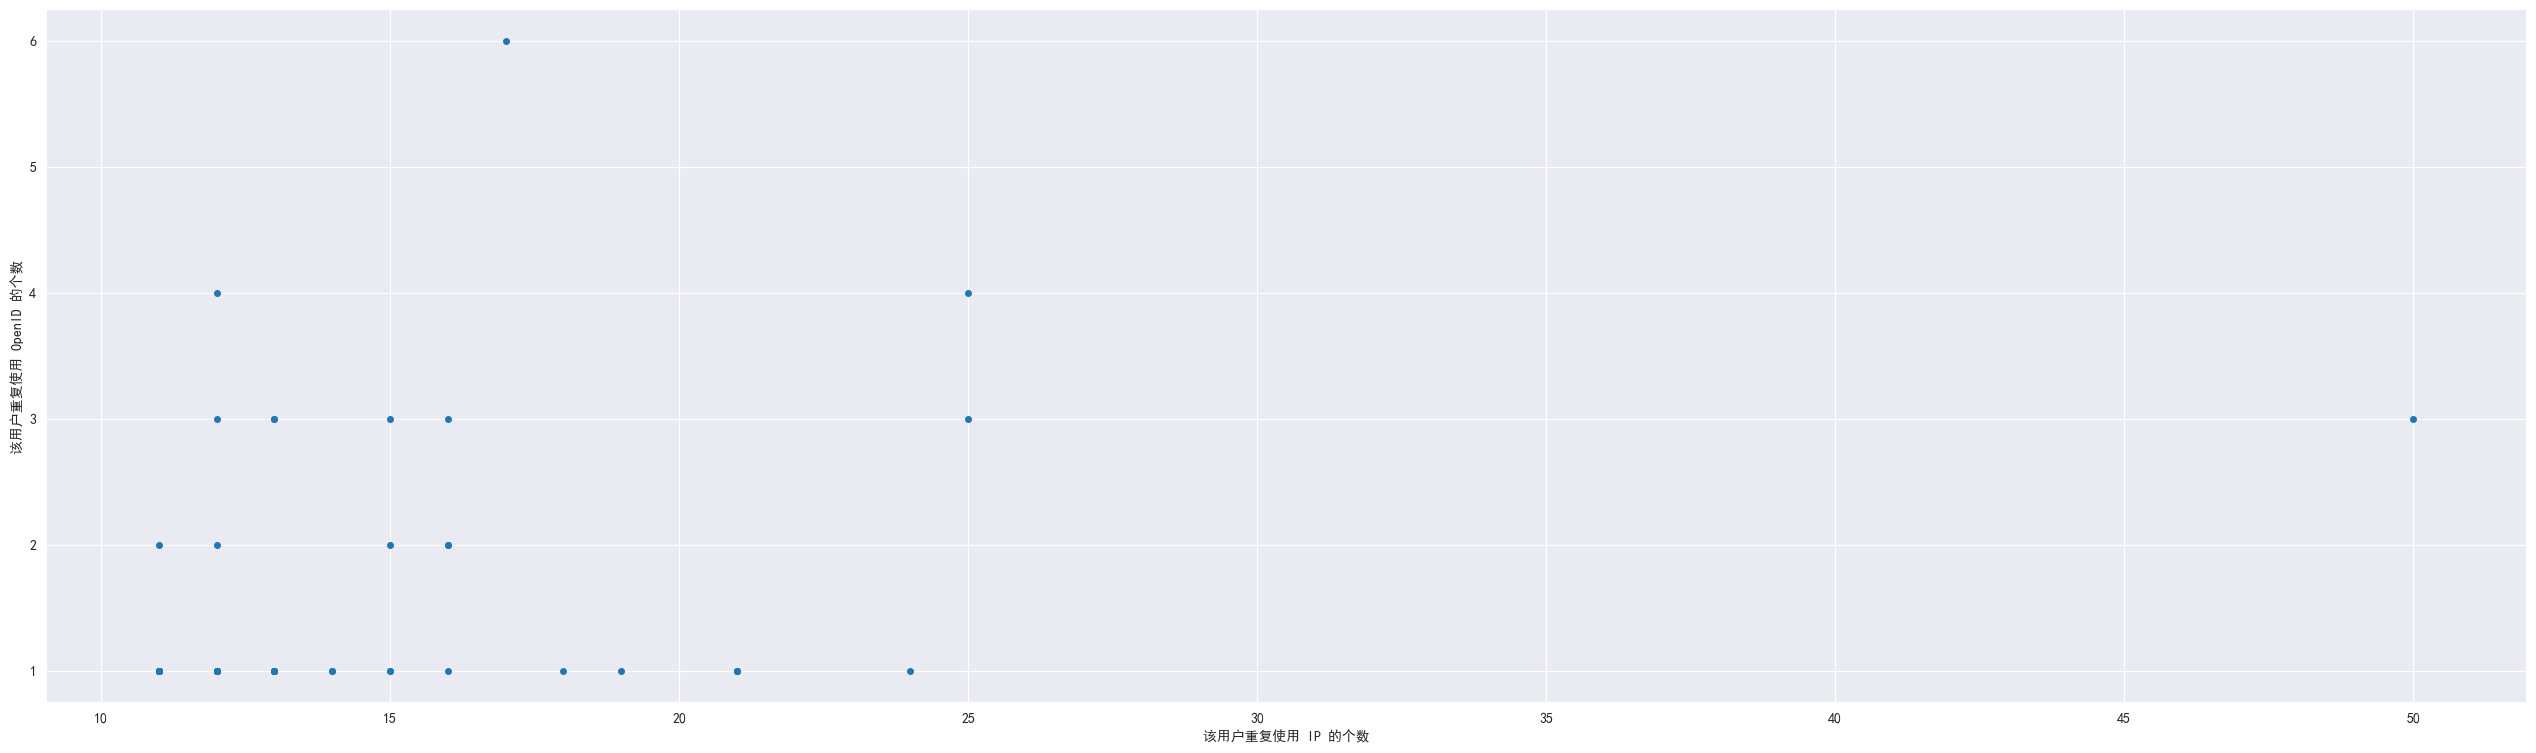

In [20]:
,  # 要求图表中只有 1 行 1 列子图，并且设置图表的大小为 10 * 10
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(32, 9))

total_rows = df.shape[0]
total_rows = 50

# x 轴不需要打印每一条 id，只需要打印刻度
ax.scatter(df.head(total_rows).ipCount,
           df.head(total_rows).openIdCount,
           s=16)

# 设置标题
ax.set_xlabel('该用户重复使用 IP 的个数')
ax.set_ylabel('该用户重复使用 OpenID 的个数')

# 设置 x 轴刻度
# ticks = np.arange(0, total_rows, 1000)
# labels = [f"{df_grouped['latestEndTime'].iloc[t]}" for t in ticks if t < total_rows] # 只打印几个时间戳作为刻度
# plt.xticks(rotation=45,fontsize=8)

# 设置 y 轴刻度精度
# plt.yticks(np.arange(0, 100, 5))

plt.savefig('./imgs/1-1所有学员的重复使用的 IP 个数和 OpenID 个数.png', dpi=800, bbox_inches='tight', pad_inches=1)
plt.show()

# 4. 大小关系图
1. 上图没有体现出数据的大小关系，可以通过点的大小来体现「重复使用了 x 个 IP 和 y 个 OpenID 」的用户量是多少
2. 对不同的 [x,y] 组合分组并计算 size
3. 然后将 size 进行归一化处理 / 开平方处理,作为点的大小

### 数据预处理

In [21]:
import math
from sklearn.preprocessing import MinMaxScaler

freq = (df
        .groupby(['ipCount', 'openIdCount'])
        .size()
        .reset_index(name='studentsNum')
        .sort_values(by='studentsNum', ascending=False))

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(freq[['studentsNum']])
sqrt_data = np.sqrt(freq[['studentsNum']])


### 叠加异常用户的标记点

In [22]:
# 读取异常用户数据：join
f_openid = '../../data/各种来源的可疑ID（可作为标签）/使用可疑OPENID验证学员（去重）.csv'
df_suspicious_openid = pd.read_csv(f_openid, dtype={'openId': 'string'})

# 连接 df_suspicious_openid 和 df
suspicious_user_id = pd.merge(left=df_suspicious_openid, right=df, left_on='students', right_on='_id', how='inner')

### 绘制图表

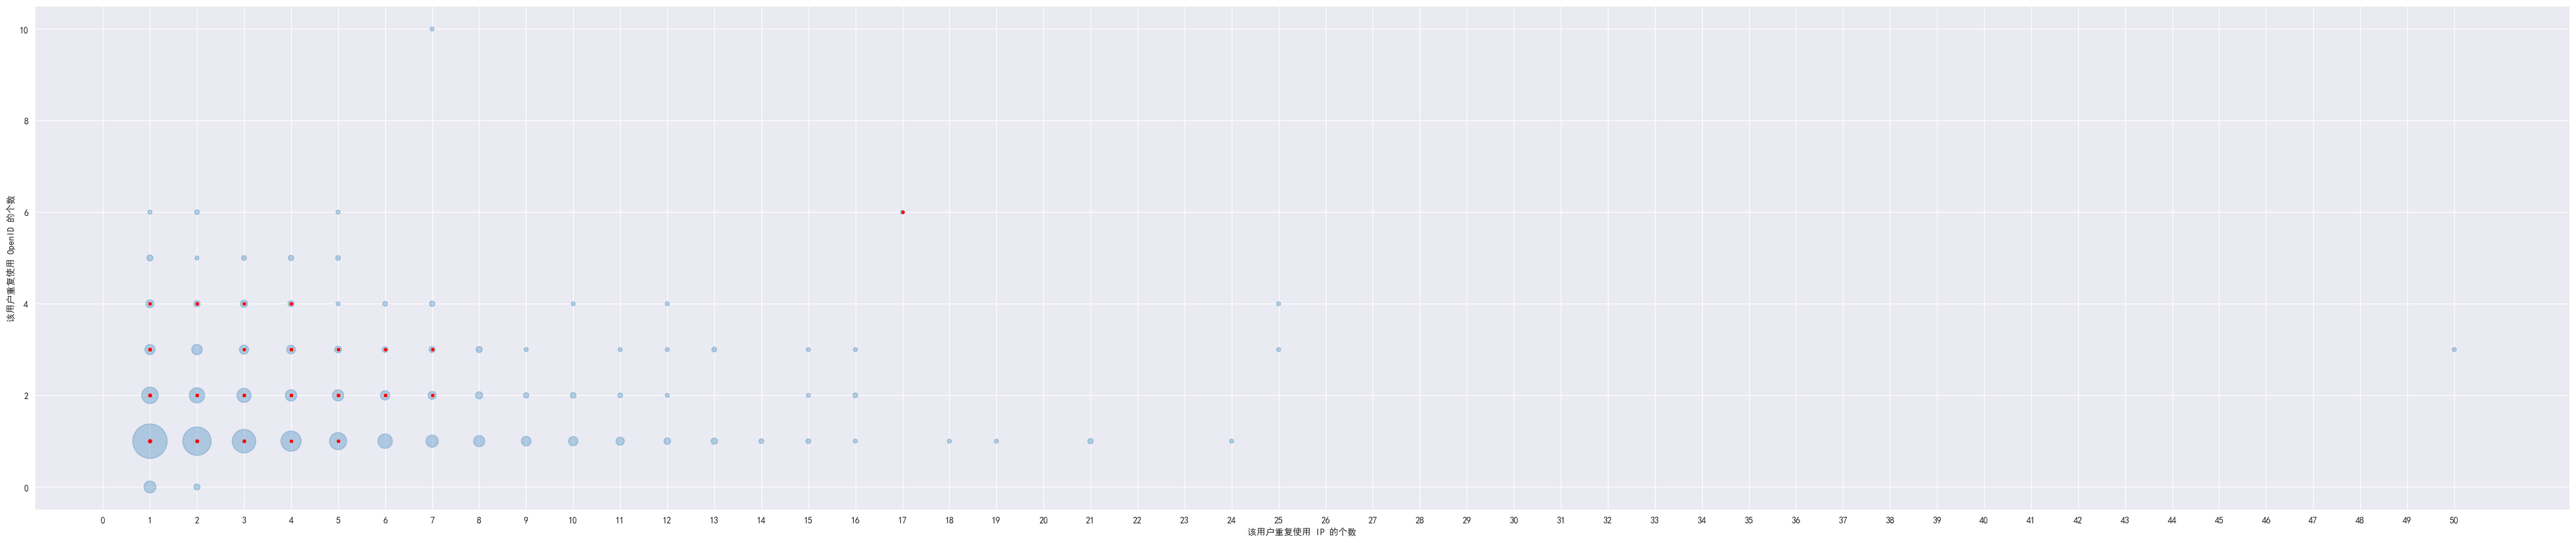

In [26]:
# 要求图表中只有 1 行 1 列子图，并且设置图表的大小为 10 * 10
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50, 10))

total_rows = freq.shape[0]
suspicious_rows = suspicious_user_id.shape[0]

# x 轴不需要打印每一条 id，只需要打印刻度
ax.scatter(freq.head(total_rows).ipCount,
           freq.head(total_rows).openIdCount,
           s=sqrt_data[:total_rows] * 20,
           alpha=0.3)

# 绘制可疑用户的标记点
ax.scatter(suspicious_user_id.head(total_rows).ipCount,
           suspicious_user_id.head(total_rows).openIdCount,
           c='red',
           s=8)

# 设置标题
ax.set_xlabel('该用户重复使用 IP 的个数')
ax.set_ylabel('该用户重复使用 OpenID 的个数')

# 设置 x 轴刻度
# ticks = np.arange(0, total_rows, 1000)
# labels = [f"{df_grouped['latestEndTime'].iloc[t]}" for t in ticks if t < total_rows] # 只打印几个时间戳作为刻度
plt.xticks(np.arange(0, freq.ipCount.max()+1, 1))

# 设置 y 轴刻度精度
# plt.yticks(np.arange(freq.openIdCount.max()))

plt.savefig('./imgs/1-3所有学员的重复使用的 IP 个数和 OpenID 个数(体现大小关系和异常用户).png', dpi=800,
            bbox_inches='tight', pad_inches=1)
plt.show()